In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, scipy
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics
import time
from model.Least_Square import Least_Square
from opt_algorithms.gradient_descent import gradient_descent
from opt_algorithms.accelerated_gradient_descent import accelerated_gradient_descent
from opt_algorithms.newton_method import newton_method
from my_utils.visualization import *
#from urllib.error import HTTPError

In [2]:
s = "../data/kc_house_data.csv"
print('From local House path:', s)
df_housesales = pd.read_csv(s, encoding='utf-8')
df_housesales['price'] = df_housesales['price'].apply(lambda x: x/1e6)
df_housesales = df_housesales[df_housesales['bedrooms']!=33]
# for col in ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']:
#   df_housesales[col] = df_housesales[col].apply(lambda x: x/1e4)
df_housesales.head()

From local House path: ../data/kc_house_data.csv


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,0.2219,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,0.5380,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,0.1800,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,0.6040,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,0.5100,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
ids = df_housesales.id.value_counts().to_frame()
ids[ids.id>=2]

,id
795000620,3
8651510380,2
7409700215,2
1995200200,2
9211500620,2
...,...
2787460720,2
3332000615,2
2206700215,2
6021501535,2


In [4]:
# Drop duplicated id
df_housesales = df_housesales.sort_values(by=['id']).drop_duplicates(subset=['id'], keep='last')

In [5]:
# Tranform Date to year, month and Drop id, Date
df_housesales['date'] = pd.to_datetime(df_housesales['date'])
df_housesales['year'] = df_housesales['date'].apply(lambda date: date.year)
df_housesales['month'] = df_housesales['date'].apply(lambda date: date.month)

In [6]:
df_housesales['yr_renovated'] = [str(x) + '-01-01' if x!=0 else str(y) + '-01-01'
                                 for x, y in zip(df_housesales['yr_renovated'].values,
                                                 df_housesales['yr_built'].values)]
df_housesales['yr_renovated'] = pd.to_datetime(df_housesales['yr_renovated'].apply(lambda x: str(x) + '-01-01'))
df_housesales['yr_built'] = pd.to_datetime(df_housesales['yr_built'].apply(lambda x: str(x) + '-01-01'))


In [7]:
df_housesales['yr_built'] = pd.to_datetime(df_housesales['yr_built'])
df_housesales['yr_renovated'] = pd.to_datetime(df_housesales['yr_renovated'])
df_housesales['built_age'] = [x - y for x,y in
                                  zip(df_housesales['date'].apply(lambda x: x.year),
                                      df_housesales['yr_built'].apply(lambda x: x.year))]
df_housesales['renovated_age'] = [x - y for x,y in
                                  zip(df_housesales['date'].apply(lambda x: x.year),
                                      df_housesales['yr_renovated'].apply(lambda x: x.year))]


In [8]:
# dropping
df_housesales.drop(['id','date','yr_built','yr_renovated'], axis = 1, inplace = True)

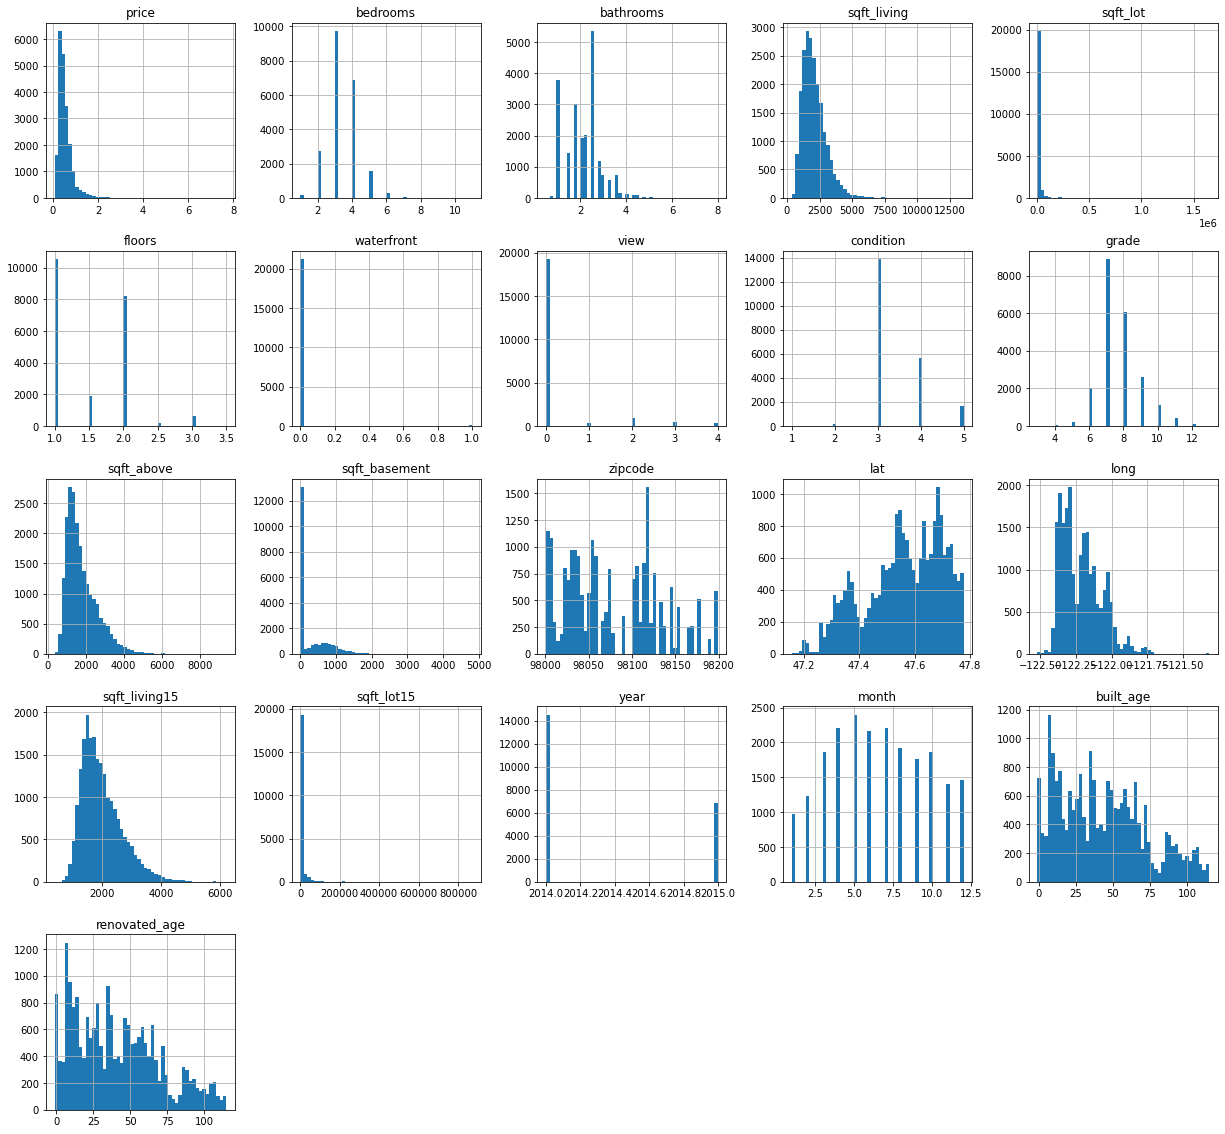

In [9]:
df_housesales.hist(bins=50, figsize=(21, 20))
plt.show()

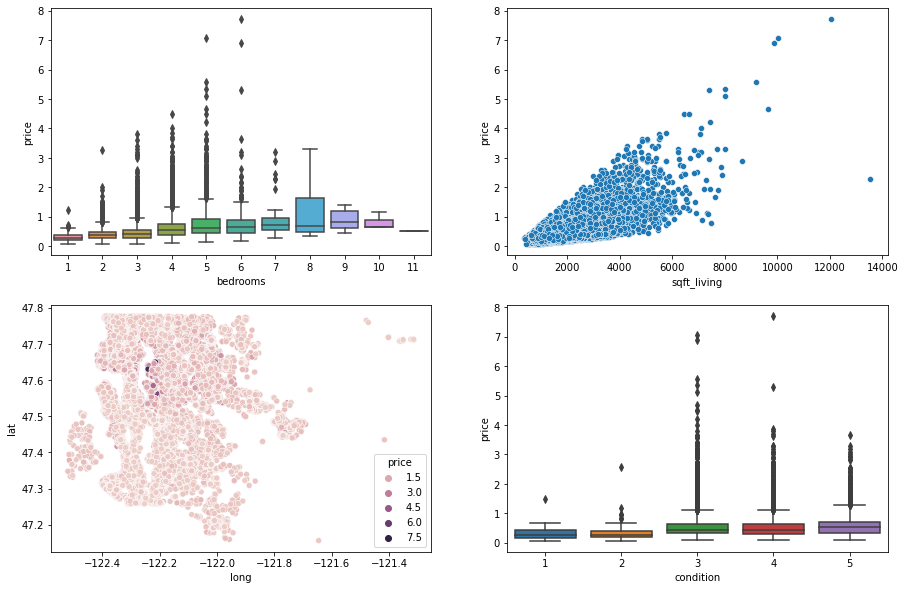

In [10]:
f,ax = plt.subplots(2,2, figsize = (15,10))
y = 'price'
sns.boxplot(x='condition', y=y, data=df_housesales , ax = ax[1,1])
sns.scatterplot(x='sqft_living',y=y ,data=df_housesales , ax = ax[0,1])
sns.scatterplot(x='long',y='lat',hue=y ,data=df_housesales , ax = ax[1,0])
sns.boxplot(x='bedrooms',y=y ,data=df_housesales , ax = ax[0,0]);

In [11]:
numerical = df_housesales.select_dtypes(['int64', 'float64'])
categorical = df_housesales.select_dtypes('object')

In [12]:
FC = df_housesales.corr() # Features Correlation
Target = numerical.corr()['price'].to_frame().reset_index() #Feature Correlation related to SalePrice
FR = FC.unstack().to_frame(name='Correlation') # Feature Relation
Feature = FR[(FR['Correlation']>=0.8)|(FR['Correlation']<=-0.8)].sort_values(by='Correlation', ascending = False).reset_index()
Final  = Feature.merge(Target,left_on='level_1', right_on='index')
Final = Final[Final['level_0'] != Final['level_1']]
#print("In thisdata set these columns are strongly related , i will usually take one and drop the other one but in this case i will keep it ")
Final

,level_0,level_1,Correlation,index,price
3,renovated_age,built_age,0.909456,built_age,-0.052136
13,sqft_living,sqft_above,0.876534,sqft_above,0.605082
21,sqft_above,sqft_living,0.876534,sqft_living,0.701769
24,built_age,renovated_age,0.909456,renovated_age,-0.104056


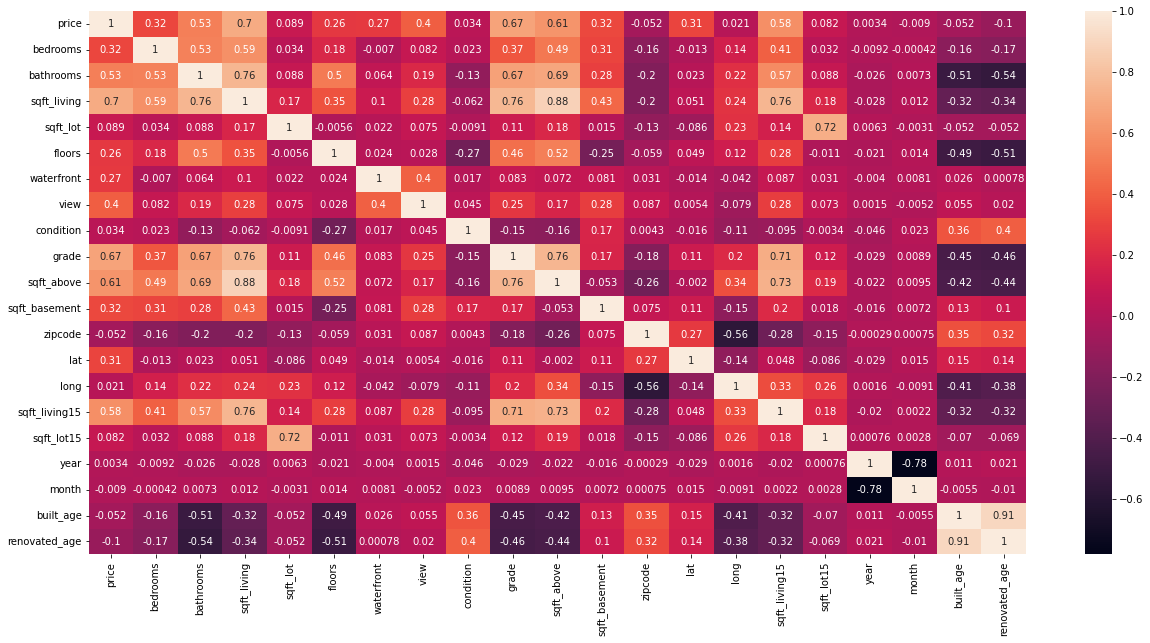

In [13]:
plt.figure(figsize=(21,10))
corr_matrix = df_housesales.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show();

In [14]:
drop_cols = ['sqft_above','year','built_age','sqft_lot15','long']
df_housesales = df_housesales.drop(columns=drop_cols)

In [15]:
# scikit-learn k-fold cross-validation
from numpy import array
from sklearn.model_selection import KFold
# data sample
# data = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9])
# prepare cross validation
kf = KFold(n_splits=3, shuffle=False)
path = '../data/'
train_path = path + 'train'
test_path = path + 'test'
for i, (t_ind, v_ind) in enumerate(kf.split(df_housesales)):
    X_train = df_housesales.iloc[t_ind]     # train set
    X_test = df_housesales.iloc[v_ind]     # validation set
    X_train.to_csv(train_path + str(i) + '.csv', index=False)
    X_test.to_csv(test_path + str(i) + '.csv', index=False)
    print(t_ind, v_ind)
    display(X_train.describe())

[ 7140  7141  7142 ... 21416 21417 21418] [   0    1    2 ... 7137 7138 7139]


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,zipcode,lat,sqft_living15,month,renovated_age
count,14279.000000,14279.000000,14279.000000,14279.000000,1.427900e+04,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000
mean,0.534805,3.369844,2.113646,2066.632117,1.125839e+04,1.497234,0.007423,0.238322,3.402339,7.655998,292.730583,98078.579662,47.562013,1979.366552,6.575741,40.765460
std,0.358199,0.898858,0.755369,892.779553,2.511815e+04,0.536824,0.085842,0.774379,0.648009,1.147427,441.938694,53.441773,0.138490,682.389639,3.109230,29.056858
min,0.080000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,4.000000,0.000000,98001.000000,47.155900,460.000000,1.000000,-1.000000
25%,0.325000,3.000000,1.750000,1430.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,0.000000,98033.000000,47.479300,1490.000000,4.000000,14.500000
50%,0.450000,3.000000,2.250000,1910.000000,7.395000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,0.000000,98065.000000,47.573200,1830.000000,6.000000,37.000000
75%,0.635000,4.000000,2.500000,2530.000000,1.011650e+04,2.000000,0.000000,0.000000,4.000000,8.000000,560.000000,98118.000000,47.680650,2350.000000,9.000000,60.000000
max,7.700000,10.000000,8.000000,12050.000000,1.164794e+06,3.500000,1.000000,4.000000,5.000000,13.000000,3480.000000,98199.000000,47.777600,6110.000000,12.000000,115.000000


[    0     1     2 ... 21416 21417 21418] [ 7140  7141  7142 ... 14277 14278 14279]


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,zipcode,lat,sqft_living15,month,renovated_age
count,14279.000000,14279.000000,14279.000000,14279.000000,1.427900e+04,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000,14279.000000
mean,0.543077,3.372995,2.129438,2094.294208,1.608668e+04,1.505568,0.007914,0.235451,3.401219,7.675327,283.901254,98077.459906,47.559039,1998.456334,6.556972,40.299811
std,0.371309,0.900943,0.767958,927.556056,4.517309e+04,0.540897,0.088609,0.769135,0.642847,1.175842,437.676355,52.515620,0.136786,691.395074,3.122083,28.990946
min,0.078000,1.000000,0.500000,380.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,0.000000,98001.000000,47.155900,399.000000,1.000000,-1.000000
25%,0.320000,3.000000,1.750000,1440.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,0.000000,98033.000000,47.469550,1490.000000,4.000000,15.000000
50%,0.455000,3.000000,2.250000,1930.000000,7.579000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,0.000000,98065.000000,47.573200,1860.000000,6.000000,36.000000
75%,0.650000,4.000000,2.500000,2570.000000,1.072300e+04,2.000000,0.000000,0.000000,4.000000,8.000000,540.000000,98117.000000,47.673600,2390.000000,9.000000,60.000000
max,7.700000,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,4820.000000,98199.000000,47.777600,6210.000000,12.000000,115.000000


[    0     1     2 ... 14277 14278 14279] [14280 14281 14282 ... 21416 21417 21418]


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,zipcode,lat,sqft_living15,month,renovated_age
count,14280.000000,14280.000000,14280.000000,14280.000000,1.428000e+04,14280.000000,14280.000000,14280.000000,14280.000000,14280.000000,14280.000000,14280.000000,14280.000000,14280.000000,14280.000000,14280.000000
mean,0.545840,3.374860,2.112255,2088.536064,1.804012e+04,1.485224,0.007493,0.231583,3.428571,7.657143,299.214566,98077.580042,47.559521,1987.421639,6.602801,41.436765
std,0.373542,0.909228,0.782542,935.377053,4.978768e+04,0.542338,0.086240,0.757952,0.658577,1.192201,448.839359,54.455103,0.140455,682.682207,3.108279,28.393221
min,0.078000,1.000000,0.500000,370.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,0.000000,98001.000000,47.159300,399.000000,1.000000,-1.000000
25%,0.323000,3.000000,1.500000,1420.000000,5.250000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,0.000000,98031.000000,47.463725,1490.000000,4.000000,17.000000
50%,0.449999,3.000000,2.250000,1910.000000,7.878500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,0.000000,98059.000000,47.570450,1840.000000,6.000000,38.000000
75%,0.649000,4.000000,2.500000,2560.000000,1.150275e+04,2.000000,0.000000,0.000000,4.000000,8.000000,580.000000,98118.000000,47.679900,2360.000000,9.000000,60.000000
max,5.570000,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,4820.000000,98199.000000,47.777600,6210.000000,12.000000,115.000000


In [16]:
index = '0'
X_train = pd.read_csv(train_path + index + '.csv')
y_train = X_train[['price']]
X_train = X_train.drop(['price'], axis = 1)
print(len(X_train))
X_test = pd.read_csv(test_path + index + '.csv')
y_test = X_test[['price']]
X_test = X_test.drop(['price'], axis = 1)
print(len(X_test))

14279
7140


In [17]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
def scale_data(scaler_type='standard', X_train_int=None, y_train=''):
    y_scaler = None
    if scaler_type == 'standard':
      x_scaler = StandardScaler()
      if len(y_train) != 0:
        y_scaler = StandardScaler()
    if scaler_type == 'robust':
      x_scaler = RobustScaler()
      if len(y_train) != 0:
        y_scaler = RobustScaler()
    x_scaler.fit(X_train_int)
    if y_scaler != None:
      y_scaler.fit(y_train)
    return x_scaler, y_scaler
x_scaler, y_scaler = scale_data(scaler_type='standard', X_train_int=X_train, y_train='')
X_train_transformed = x_scaler.transform(X_train)
if  y_scaler != None:
  y_train_transformed = y_scaler.transform(y_train)
else:
  y_train_transformed = y_train

In [21]:
A = np.c_[X_train_transformed, np.ones(X_train_transformed.shape[0])]
b = y_train_transformed.to_numpy().flatten()

In [22]:
# A = np.c_[X_train, np.ones(X_train.shape[0])]
# b = y_train.to_numpy().flatten()
ls = Least_Square(A, b)
ls.hess

array([[ 2.00000000e+00,  1.03763509e+00,  1.18741174e+00,
         1.01949894e-01,  3.58690727e-01,  5.07683964e-03,
         1.96899091e-01,  5.44093335e-02,  7.11623712e-01,
         6.22042744e-01, -3.17377324e-01, -6.25595308e-02,
         8.23690340e-01, -9.99841723e-03, -3.37147999e-01,
         4.85671062e-16],
       [ 1.03763509e+00,  2.00000000e+00,  1.49220856e+00,
         1.42658337e-01,  1.01079385e+00,  1.25193648e-01,
         3.79442294e-01, -2.46576182e-01,  1.31395714e+00,
         5.59347339e-01, -4.37913815e-01, -3.87256617e-03,
         1.16250433e+00,  7.58461592e-04, -1.09101202e+00,
        -1.31370041e-16],
       [ 1.18741174e+00,  1.49220856e+00,  2.00000000e+00,
         3.33840400e-01,  6.90169490e-01,  2.13207201e-01,
         5.86083348e-01, -1.16681909e-01,  1.50465754e+00,
         8.69303586e-01, -4.35156602e-01,  5.21161089e-02,
         1.53887876e+00,  1.71691024e-02, -6.85389947e-01,
         2.03026428e-16],
       [ 1.01949894e-01,  1.42658337e

# Gradient Descent

## Without Backtracking LineSearch

In [23]:
config = []
for alpha_ in [1e-1, 1e-2, 1e-3]:
    gd = gradient_descent(ls, alpha=alpha_)
    tmp = {
                'optimation': 'GD',
                'use_backtracking': False,
                'parameter': {
                    'alpha': str(alpha_),
                },
                'result': gd
            }
    config.append(tmp)
config_ = print_result(config)

GD finished after 397 iterations
GD finished after 3649 iterations
GD finished after 17109 iterations


## With Backtracking LineSearch

In [24]:
config = []
for alpha_bar in [0.1,0.5,1]:
    for ro  in [0.1, 0.5, 0.9]:
        for c in [0.1, 0.5, 0.9]:
            gd_ls = gradient_descent(ls=ls, use_line_search=True, alpha_bar=alpha_bar, ro=ro, c=c)
            tmp = {
                'optimation': 'GD',
                'use_backtracking': True,
                'parameter': {
                    'alpha_bar': str(alpha_bar),
                    'ro': str(ro),
                    'c': str(c)
                },
                'result': gd_ls
            }
            config.append(tmp)
config_ = print_result(config)

GD finished after 351 iterations
GD finished after 410 iterations
GD finished after 477 iterations
GD finished after 432 iterations
GD finished after 405 iterations
GD finished after 421 iterations
GD finished after 373 iterations
GD finished after 359 iterations
GD finished after 388 iterations
GD finished after 229 iterations
GD finished after 177 iterations
GD finished after 331 iterations
GD finished after 146 iterations
GD finished after 132 iterations
GD finished after 121 iterations
GD finished after 184 iterations
GD finished after 146 iterations
GD finished after 132 iterations
GD finished after 132 iterations
GD finished after 120 iterations
GD finished after 467 iterations
GD finished after 91 iterations
GD finished after 83 iterations
GD finished after 141 iterations
GD finished after 200 iterations
GD finished after 126 iterations
GD finished after 116 iterations


# Accelerated Gradient Descent

## Without Backtracking LineSearch

In [25]:
config = []
for alpha_ in [0.1, 0.01, 0.001]:
    agd = accelerated_gradient_descent(ls=ls, alpha=alpha_)
    tmp = {
                'optimation': 'AGD',
                'use_backtracking': False,
                'parameter': {
                    'alpha': str(alpha_),
                },
                'result': agd
            }
    config.append(tmp)
config_ = print_result(config)

GD finished after 391 iterations
GD finished after 1998 iterations
GD finished after 9317 iterations


## With Backtracking LineSearch

In [26]:
config = []
for alpha_bar in [0.1,0.5,1]:
    for ro  in [0.1, 0.5, 0.9]:
        for c in [0.1, 0.5, 0.9]:
            agd_ls = accelerated_gradient_descent(ls=ls, use_linesearch=True, alpha_bar=alpha_bar, ro=ro, c=c)
            tmp = {
                'optimation': 'AGD',
                'use_backtracking': True,
                'parameter': {
                    'alpha_bar': str(alpha_bar),
                    'ro': str(ro),
                    'c': str(c)
                },
                'result': agd_ls
            }
            config.append(tmp)
config_ = print_result(config)

GD finished after 292 iterations
GD finished after 292 iterations
GD finished after 361 iterations
GD finished after 371 iterations
GD finished after 391 iterations
GD finished after 372 iterations
GD finished after 371 iterations
GD finished after 292 iterations
GD finished after 312 iterations
GD finished after 1581 iterations


/Users/thanhnk/Documents/phuongntm/master/hk2/toi_uu_hoa_nang_cao/advanced-optimization/src/model/Least_Square.py:28: RuntimeWarning: overflow encountered in matmul
  return (x.T @ self.B @ x - self.C_T @ x + self.d)/self.m
/Users/thanhnk/Documents/phuongntm/master/hk2/toi_uu_hoa_nang_cao/advanced-optimization/src/backtracking_method/backtracking_linesearch.py:11: RuntimeWarning: overflow encountered in matmul
  grad_p_k = c*(grad_k.T@p_k)
/Users/thanhnk/Documents/phuongntm/master/hk2/toi_uu_hoa_nang_cao/advanced-optimization/src/backtracking_method/backtracking_linesearch.py:14: RuntimeWarning: invalid value encountered in double_scalars
  while f_new > f_k + alpha*grad_p_k:


GD finished after 4179 iterations
GD finished after 9999 iterations
GD finished after 206 iterations
GD finished after 226 iterations
GD finished after 364 iterations
GD finished after 651 iterations
GD finished after 187 iterations
GD finished after 290 iterations
GD finished after 1441 iterations
GD finished after 2765 iterations
GD finished after 416 iterations
GD finished after 178 iterations
GD finished after 243 iterations
GD finished after 359 iterations

/Users/thanhnk/Documents/phuongntm/master/hk2/toi_uu_hoa_nang_cao/advanced-optimization/src/model/Least_Square.py:28: RuntimeWarning: invalid value encountered in matmul
  return (x.T @ self.B @ x - self.C_T @ x + self.d)/self.m



GD finished after 536 iterations
GD finished after 184 iterations
GD finished after 295 iterations


# Newton Method

## Without Backtracking LineSearch

In [27]:
config = []
for alpha_ in [1,
               1e-1,
               1e-2,
              ]:
    nt = newton_method(ls=ls, alpha=alpha_)
    tmp = {
                'optimation': 'Newton',
                'use_backtracking': False,
                'parameter': {
                    'alpha': str(alpha_),
                },
                'result': nt
            }
    config.append(tmp)
print_result(config)

GD finished after 1 iterations
GD finished after 129 iterations
GD finished after 1090 iterations


,algorithm,parameters,stop_iteration,final_fvalue,total_time
0,Newton,0_alpha=1,1,0.041646,0.000456
1,Newton,1_alpha=0.1,129,0.041646,0.007556
2,Newton,2_alpha=0.01,1090,0.041646,0.057061


## With Backtracking LineSearch

In [29]:
config = []
for alpha_bar in [1]:
    for ro  in [0.1, 0.5, 0.9]:
        for c in [0.1, 0.5, 0.9]:
            nt_ls = newton_method(ls=ls, use_linesearch=True, alpha_bar=alpha_bar, ro=ro, c=c)
            tmp = {
                'optimation': 'Newton',
                'use_backtracking': True,
                'parameter': {
                    'alpha_bar': str(alpha_bar),
                    'ro': str(ro),
                    'c': str(c)
                },
                'result': nt_ls
            }
            config.append(tmp)
print_result(config)

GD finished after 126 iterations
GD finished after 128 iterations
GD finished after 1100 iterations
GD finished after 51 iterations
GD finished after 50 iterations
GD finished after 756 iterations
GD finished after 12 iterations
GD finished after 27 iterations
GD finished after 352 iterations


,algorithm,parameters,stop_iteration,final_fvalue,total_time
0,Newton_LS,0_alpha_bar=1_ro=0.1_c=0.1,126,0.041646,0.010450
1,Newton_LS,1_alpha_bar=1_ro=0.1_c=0.5,128,0.041646,0.012050
2,Newton_LS,2_alpha_bar=1_ro=0.1_c=0.9,1100,0.041646,0.097141
3,Newton_LS,3_alpha_bar=1_ro=0.5_c=0.1,51,0.041646,0.003836
4,Newton_LS,4_alpha_bar=1_ro=0.5_c=0.5,50,0.041646,0.003878
5,Newton_LS,5_alpha_bar=1_ro=0.5_c=0.9,756,0.041646,0.071966
6,Newton_LS,6_alpha_bar=1_ro=0.9_c=0.1,12,0.041646,0.000957
7,Newton_LS,7_alpha_bar=1_ro=0.9_c=0.5,27,0.041646,0.002547
8,Newton_LS,8_alpha_bar=1_ro=0.9_c=0.9,352,0.041646,0.079635
